In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from malnis import show
from nltk.tokenize import word_tokenize
from tqdm.auto import tqdm
import scipy.sparse as sp
from sklearn.linear_model import LogisticRegression 
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.decomposition import PCA, SparsePCA
from sklearn.metrics import accuracy_score, f1_score, auc, roc_auc_score, average_precision_score, PrecisionRecallDisplay
import numpy as np


In [2]:
pwd

'/home/jarobyte/phd/projects/malnis_dataset/notebooks'

In [3]:
data = pd.read_pickle("../data/labels.pkl")#.head(50)
show(data)

(391, 8)


,query,document,summary,r1,r2,rl,sentences,relevance
36,"For many types of machine learning algorithms,...","field in computer science, and health informat...",[While the techniques for neural networks are ...,0.594595,0.485714,0.594595,"[field in computer science, and health informa...","[False, False, False, False, False, False, Fal..."
38,We consider the problem of learning good traje...,"field in computer science, and health informat...",[[71] considered the problem of learning good ...,0.646766,0.478571,0.636816,"[field in computer science, and health informa...","[False, False, False, False, False, False, Fal..."
136,We study in this work the importance of depth ...,Deep Learning Based Text Classification: A Com...,[[57] show that deep models indeed outperform ...,0.533333,0.403101,0.533333,[Deep Learning Based Text Classification: A Co...,"[False, False, False, False, False, False, Fal..."
5,We investigate a lattice-structured LSTM model...,1041-4347 (c) 2020 IEEE. Personal use is permi...,[Zhang and Yang [149] proposed a lattice-struc...,0.478261,0.393162,0.478261,"[1041-4347 (c) 2020 IEEE., Personal use is per...","[False, False, False, False, False, False, Fal..."
316,"HDBSCAN*, a state-of-the-art density-based hie...",PVLDB Reference Format: Antonio Cavalcante Ara...,"[In [6], the authors proposed RNG-HDBSCAN*, a ...",0.539062,0.350365,0.507812,[PVLDB Reference Format: Antonio Cavalcante Ar...,"[False, False, False, False, False, False, Fal..."


In [4]:
vectorizer = TfidfVectorizer(
#     vocabulary = vocabulary
#     max_features = 10000
)
# vectorizer
vectorizer.fit(data.document)

TfidfVectorizer()

In [5]:
query_embeddings = vectorizer.transform(data["query"])#.toarray()
query_embeddings.shape

(391, 37119)

In [6]:
dims = query_embeddings.shape[1]
sentence_embeddings = [
    vectorizer.transform(l)#.toarray() 
    for l in tqdm(data.sentences)
]
all([l.shape[1] == dims for l in sentence_embeddings])

  0%|          | 0/391 [00:00<?, ?it/s]

True

In [7]:
query_embeddings.shape[0] == len(sentence_embeddings)

True

In [8]:
sum([len(l) for l in tqdm(data.sentences)])

  0%|          | 0/391 [00:00<?, ?it/s]

222254

In [9]:
train = [
#     sp.hstack([q, s])
#     (-q).power(2)
    ((sp.csr_matrix(np.ones([l.shape[0],1])) * q) - l).power(2)
    for q, l in zip(query_embeddings, tqdm(sentence_embeddings))
]
len(train)

  0%|          | 0/391 [00:00<?, ?it/s]

391

In [10]:
X = sp.vstack(train)#.toarray().T#.squeeze()
X.shape

(222254, 37119)

In [11]:
Y = np.array([y for l in tqdm(data.relevance) for y in l])
Y.shape

  0%|          | 0/391 [00:00<?, ?it/s]

(222254,)

In [12]:
Y.mean()

0.01725953188694017

In [13]:
%%time
lr = LogisticRegression(
    C = 10**-2
)
lr.fit(X, Y)

predictions = lr.predict_proba(X)

# predictions.sum()
predictions.shape

CPU times: user 3.68 s, sys: 6.71 s, total: 10.4 s
Wall time: 3.67 s


(222254, 2)

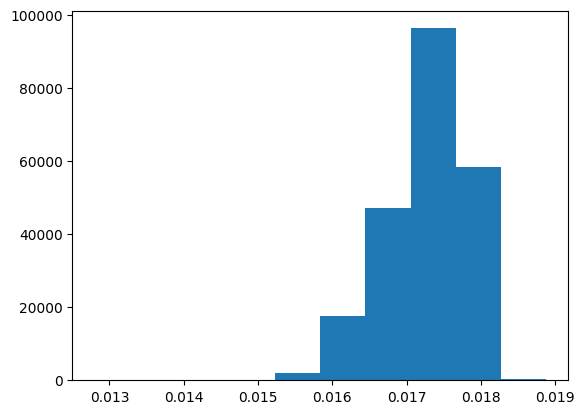

In [14]:
plt.hist(predictions[:, 1])
# plt.xlim(-0.1, 1.1)
plt.show()

In [15]:
roc_auc_score(Y, predictions[:, 1])

0.7113852192089307

In [16]:
average_precision_score(Y, predictions[:, 1])

0.0429214893049127

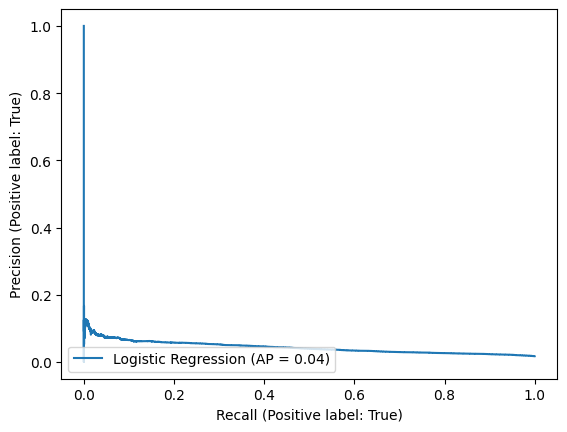

In [17]:
display = PrecisionRecallDisplay.from_estimator(
    lr, X, Y, name="Logistic Regression"
)